# Model training

Data type: 
- explanatory variable: both categorical and numerical
- response variable: numerical

Possible model choice
- xgboost
- deep learning model(hash the categorical variables to numeric)
- 

In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## data splitting

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_df = pd.read_csv("//content/drive/My Drive/data/train_exp.csv")

In [0]:
X_df = train_df.drop(['id',"scalar_coupling_constant","molecule_name",'atom_index_0','atom_index_1'],axis=1)
y_df = train_df["scalar_coupling_constant"]

In [0]:
def label_func():
    for i in ['type','atom_0','atom_1']:
        lb_make = LabelEncoder()
        X_df[i] = lb_make.fit_transform(X_df[i])
label_func()

In [6]:
train_X, val_X, train_y, val_y = train_test_split(X_df,y_df, test_size = 0.2, random_state=1,stratify=X_df.type)
print(train_X.shape)
print(val_X.shape)

(3726517, 13)
(931630, 13)


## deep learning model

In [0]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_X.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(96, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [0]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [11]:
k = 4
num_epochs = 200
num_val_samples = len(train_X) // k
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_X[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_y[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_X[:i * num_val_samples],
         train_X[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_y[:i * num_val_samples],
         train_y[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=600, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


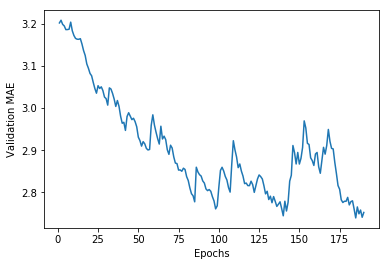

In [24]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [25]:
np.argmin(smooth_mae_history) + 1

185

## model evaluation

In [0]:
## best epochs =185 by now
num_epochs = 185
model = build_model()
history = model.fit(train_X, train_y,
                    validation_data=(val_X, val_y),
                    epochs=num_epochs, batch_size=500, verbose=0)
mae_history = history.history['val_mean_absolute_error']

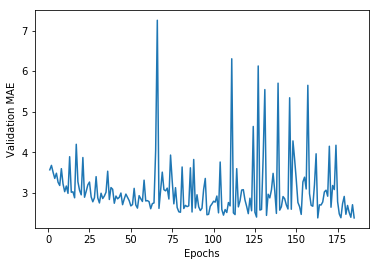

In [27]:
plt.plot(range(1, len(mae_history) + 1), mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [0]:
def score_per_type(x):
    return np.log(np.mean(np.abs(x['pred_coupling_constant'].values - x['scalar_coupling_constant'].values)))

def evaluation_score(results_df):
    results = results_df[['scalar_coupling_constant','pred_coupling_constant','type']].groupby("type")
    return np.mean(results.apply(score_per_type))

In [29]:
val_X['pred_coupling_constant'] = model.predict(val_X)
val_X['scalar_coupling_constant'] = val_y
evaluation_score(val_X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.7441882900408238

## Final result check

In [0]:
test_df = pd.read_csv("//content/drive/My Drive/data/test_exp.csv")
test_df['id'] = test_df['id'].astype(int)
X_df = test_df.drop(['id',"molecule_name",'atom_index_0','atom_index_1'],axis=1)
label_func()
test_df["scalar_coupling_constant"] = model.predict(X_df)

In [0]:
test_df[["id","scalar_coupling_constant"]].to_csv("//content/drive/My Drive/data/submission_final.csv",index=False)